In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import date


%matplotlib inline
pd.set_option('display.max_columns', 500)

 # Load and Clean Data

In [207]:
users = pd.read_csv('takehome_users.csv',  encoding='cp1252')
engagement = pd.read_csv('takehome_user_engagement.csv')

In [208]:
users.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

In [209]:
users['last_session_creation_time'] = users['last_session_creation_time'].astype(str)
users['last_session_creation_time'] = users['last_session_creation_time'].astype(float)
users['creation_time'] = pd.to_datetime(users['creation_time'], format = '%m/%d/%Y %H:%M')

In [210]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:00,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:00,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:00,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:00,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:00,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [211]:
users.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time           float64
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
dtype: object

In [212]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [213]:
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'], format = '%Y-%m-%d %H:%M:%S')

In [214]:
engagement.dtypes

time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object

# Perform Predictive Analysis

** Purpose: ** To design an algorithm to predict Adopted User. For the purposes of this analysis, an adopted user is someone who has logged into the product on three separate dayes in at least one seven-day period.

In [215]:
engSeven = engagement.copy()
engSeven.set_index('time_stamp', inplace = True)
engSeven = engSeven.groupby('user_id').resample('7D').sum()

engSeven['adopted'] = np.where(engSeven['visited'] >= 3, 1, 0)
engSeven.drop(['user_id', 'visited'], inplace = True, axis = 1)
engSeven.reset_index(inplace=True)

engSeven.head()

,user_id,time_stamp,adopted
0,1,2014-04-22 03:53:30,0
1,2,2013-11-15 03:45:04,0
2,2,2013-11-22 03:45:04,0
3,2,2013-11-29 03:45:04,0
4,2,2013-12-06 03:45:04,0


In [216]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:00,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:00,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:00,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:00,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:00,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [217]:
engagement['count'] = engagement.groupby('user_id')['visited'].transform('sum')
userCounts = engagement[['user_id', 'count']].drop_duplicates(['user_id', 'count'], inplace = False)
userCounts.head()

,user_id,count
0,1,1
1,2,14
15,3,1
16,4,1
17,5,1


In [218]:
#NA User ids
print(users[users['invited_by_user_id'] == 9999.0].shape[0])
users['invited_by_user_id'].fillna(9999, inplace = True)

users['invited_by_user_id'] = users['invited_by_user_id'].astype(int)

#subset email provider
users['emailCo'] = users['email'].str.split('@', expand=True)[1]
users['emailCo'] = users['emailCo'].str.split('.', expand=True)[0]

#drop irrelevant user features
users.drop(['creation_time', 'name', 'last_session_creation_time', 'email'], axis = 1, inplace = True)

#dummify categorical
users = pd.get_dummies(users, columns = ['emailCo', 'creation_source'])

0


In [219]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Columns: 1194 entries, object_id to creation_source_SIGNUP_GOOGLE_AUTH
dtypes: int32(1), int64(4), uint8(1189)
memory usage: 14.0 MB


In [220]:
users.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,emailCo_abdnf,emailCo_adpql,emailCo_aerbd,emailCo_aethf,emailCo_afzjt,emailCo_agfei,emailCo_aiouj,emailCo_aipbl,emailCo_ajrkw,emailCo_akwfl,emailCo_aldgv,emailCo_amknl,emailCo_amlsi,emailCo_anmvu,emailCo_anogl,emailCo_aosyq,emailCo_aotcc,emailCo_aotdh,emailCo_apagc,emailCo_aqdqw,emailCo_aqeyf,emailCo_aqfdy,emailCo_arhlj,emailCo_arlem,emailCo_aspsy,emailCo_atury,emailCo_avfnw,emailCo_axpfh,emailCo_bawmq,emailCo_bbdkr,emailCo_bberx,emailCo_bchdw,emailCo_bchfd,emailCo_bcihn,emailCo_bciky,emailCo_bcilf,emailCo_bdlvv,emailCo_bdnfn,emailCo_beszv,emailCo_bfukq,emailCo_bfvoj,emailCo_bfwtg,emailCo_bfxyd,emailCo_bgdtm,emailCo_bgdut,emailCo_bgdwc,emailCo_bhisp,emailCo_bhjwj,emailCo_bikch,emailCo_biljj,emailCo_binqn,emailCo_bjtqb,emailCo_bjtrd,emailCo_bkwgm,emailCo_bnklb,emailCo_bnmwx,emailCo_bosvd,emailCo_bqbik,emailCo_bqdse,emailCo_breuo,emailCo_brhlk,emailCo_brjuu,emailCo_bsjsm,emailCo_bsmgs,emailCo_bsmic,emailCo_bsoph,emailCo_btoph,emailCo_btpuf,emailCo_btrfw,emailCo_btsil,emailCo_bttmc,emailCo_btusf,emailCo_bvcwd,emailCo_bxlng,emailCo_bztur,emailCo_bztuu,emailCo_cauwd,emailCo_cavde,emailCo_cbbzw,emailCo_cbxln,emailCo_cbype,emailCo_cbysr,emailCo_cbyst,emailCo_cceoj,emailCo_cdhew,emailCo_cdkrd,emailCo_ceneg,emailCo_ceoiv,emailCo_ceqro,emailCo_cfqpe,emailCo_cfrwi,emailCo_cfthc,emailCo_cgbld,emailCo_cgdsi,emailCo_chcor,emailCo_chdsg,emailCo_cilfr,emailCo_cjnmy,emailCo_cjpwo,emailCo_cjpwq,emailCo_cksla,emailCo_ckslb,emailCo_cksld,emailCo_ckuun,emailCo_ckvbo,emailCo_ckvwz,emailCo_clbuw,emailCo_clwdx,emailCo_cmbwg,emailCo_cmhvk,emailCo_cnjik,emailCo_cnkin,emailCo_cnkkt,emailCo_conxa,emailCo_copkb,emailCo_cptyp,emailCo_cpugt,emailCo_cpvie,emailCo_crcly,emailCo_crdnh,emailCo_creup,emailCo_crfxb,emailCo_crfye,emailCo_crgak,emailCo_cshit,emailCo_csiml,emailCo_cslyn,emailCo_csmdd,emailCo_ctppi,emailCo_curaa,emailCo_cuvox,emailCo_cuvrx,emailCo_cuvvr,emailCo_cvcvy,emailCo_cvvth,emailCo_cvwyc,emailCo_cvzle,emailCo_cwbpy,emailCo_cwecb,emailCo_cweei,emailCo_cwgpf,emailCo_cxiue,emailCo_cxlhf,emailCo_cylik,emailCo_cymqs,emailCo_cynti,emailCo_cyqff,emailCo_dariq,emailCo_darkw,emailCo_dbsor,emailCo_dbspu,emailCo_dbvdd,emailCo_dbxmo,emailCo_deltl,emailCo_demvu,emailCo_dfohs,emailCo_dhafc,emailCo_dieyg,emailCo_dieyh,emailCo_difbq,emailCo_diged,emailCo_dihjz,emailCo_djkvd,emailCo_djmie,emailCo_djopl,emailCo_djoqq,emailCo_dkpsw,emailCo_dmbrh,emailCo_dmbtr,emailCo_dmzpz,emailCo_dnhuf,emailCo_doiac,emailCo_dppey,emailCo_dpphp,emailCo_dpqmm,emailCo_dqsut,emailCo_dqtzp,emailCo_dqwln,emailCo_dseth,emailCo_dshfd,emailCo_dshis,emailCo_dtniy,emailCo_dvseo,emailCo_dvthf,emailCo_dvtjm,emailCo_dvyir,emailCo_dwald,emailCo_dwctl,emailCo_dxjxn,emailCo_dyjzw,emailCo_dzpyd,emailCo_eanqq,emailCo_eaouk,emailCo_ecbua,emailCo_ecwgn,emailCo_eeknk,emailCo_eelqy,emailCo_efkkv,emailCo_egruv,emailCo_egsva,emailCo_egtdh,emailCo_ehwrq,emailCo_ejfbo,emailCo_ekkwg,emailCo_ekmhw,emailCo_ekoql,emailCo_elpty,emailCo_elpuc,emailCo_elqvg,emailCo_elvth,emailCo_emwyd,emailCo_encuw,emailCo_encwc,emailCo_enefm,emailCo_eokfv,emailCo_eqrnp,emailCo_eqtvz,emailCo_erayt,emailCo_erucb,emailCo_eryuz,emailCo_escgx,emailCo_esepm,emailCo_etgai,emailCo_etgyd,emailCo_evtgx,emailCo_evumx,emailCo_ewybl,emailCo_eyhov,emailCo_eykdh,emailCo_ezlig,emailCo_ezmko,emailCo_ezmmv,emailCo_eznoh,emailCo_fboqn,emailCo_fbouh,emailCo_fbqbi,emailCo_fbsio,emailCo_feibf,emailCo_fgnyh,emailCo_fhufq,emailCo_fiacj,emailCo_fizyt,emailCo_fjgzh,emailCo_fkheb,emailCo_fkhiq,...,emailCo_uuppd,emailCo_uvtjm,emailCo_uvvsz,emailCo_uvxbk,emailCo_uwbnp,emailCo_uwbpx,emailCo_uwyfe,emailCo_uwzjs,emailCo_uxebt,emailCo_uxffl,emailCo_uyhoy,emailCo_uyjys,emailCo_uznoh,emailCo_vbsly,emailCo_vcxiw,emailCo_vdarj,emailCo_veibh,emailCo_vflsd,emailCo_vfmup,emailCo_vgrpz,emailCo_vgrqg,emailCo_vgtej,emailCo_vhugu,emailCo_viadn,emailCo_vibet,emailCo_vievr,emailCo_vifbq,emailCo_viyyv,emailCo_vkjsm,emailCo_vkmdh,emailCo_vkmgt,emailCo_vknkm,emailCo_vlquf,emailCo_vlqyu,e

In [221]:
df = pd.merge(engSeven, users, left_on = ['user_id'], right_on = ['object_id'], how = 'left')
df = pd.merge(df, userCounts, left_on = ['invited_by_user_id'], right_on = ['user_id'], how = 'left')
df['count'].fillna(0, inplace = True)
df.drop(['user_id_y', 'time_stamp'], axis = 1, inplace = True)

**Logistic Regression**

In [222]:
from sklearn.model_selection import train_test_split

target = df['adopted']
variables = df.copy()
variables.drop('adopted', axis = 1, inplace = True)

x_train, x_test, y_train, y_test = train_test_split(variables, target, test_size=0.25, random_state=0)

In [223]:
from sklearn.linear_model import LogisticRegression

#create object
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)


predictions = logisticRegr.predict(x_test)

score = logisticRegr.score(x_test, y_test)
print(score)

0.5869231910579158


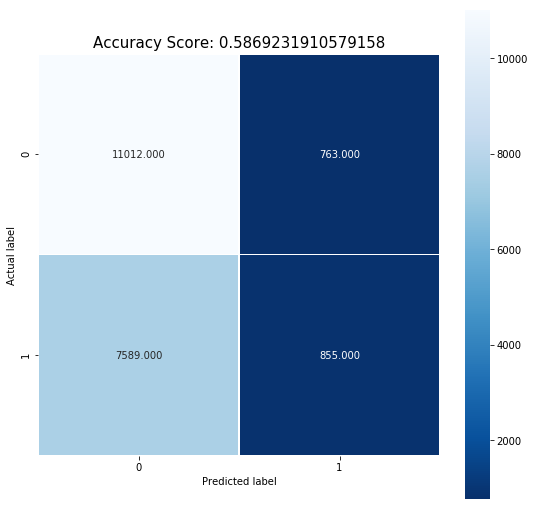

In [224]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

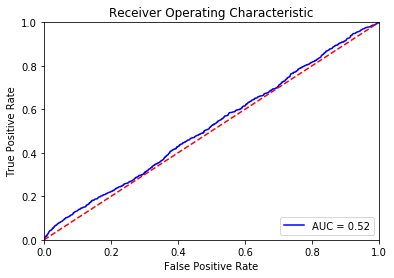

In [225]:
# calculate the fpr and tpr for all thresholds of the classification
probs = logisticRegr.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [226]:
fieldList = np.array(list(variables)).reshape(-1,1)

coeffs = np.reshape(np.round(logisticRegr.coef_,5),(-1,1))
coeffs=np.concatenate((fieldList,coeffs),axis=1)
coeffs = pd.DataFrame(coeffs,columns=['Field','Coeff'])
coeffs.sort_values(['Coeff'], ascending = False)

,Field,Coeff
751,emailCo_qqgix,4e-05
268,emailCo_fsdmy,3e-05
250,emailCo_fkhiq,3e-05
1036,emailCo_wqnsa,2e-05
180,emailCo_dpqmm,2e-05
724,emailCo_qcnhy,2e-05
722,emailCo_qcinn,2e-05
389,emailCo_igiwm,2e-05
56,emailCo_binqn,2e-05
81,emailCo_bztuu,2e-05


**Conclusion:** Unfortunately, our model performed relatively poorly as we only achieved an AUC of .52. We did learn that customers signing up from certain email companies may be predictive of retention. A more robust model such as a random forest, gradient boosted decision tree, or deep learning model would be more appropriate given the number of predictors.